In [1]:
using PyPlot

In [2]:
"""plot line y = w*x+b"""
function plotline(w,b;
                  xmin=-100,xmax=100)
    xsamples = [xmin, xmax]
    plot(xsamples, [w*x+b for x in xsamples], color="black")
end

plotline

In [3]:
"""plot function y=f(x)"""
function plotfunc(f;
                  xmin=-100,xmax=100,nsamples=100)
    xsamples = linspace(xmin,xmax,nsamples)
    plot(xsamples, [f(x) for x in xsamples], color="black")
end

plotfunc

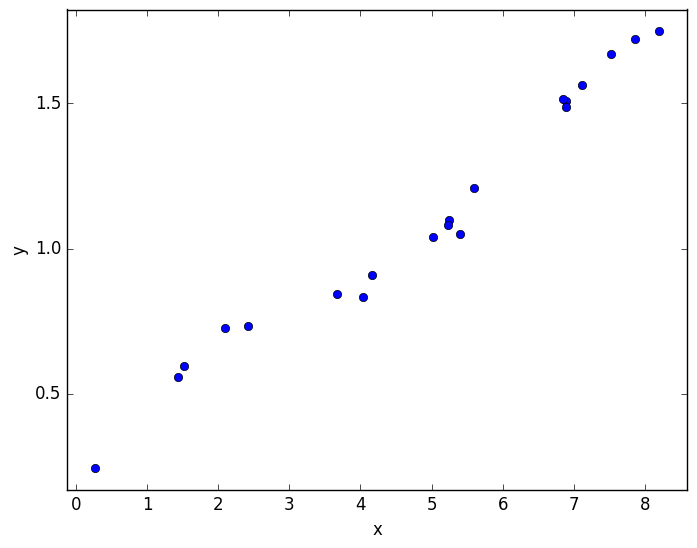

(-0.12472290408977926,8.589481557384227)

In [4]:
# Generate and plot data
srand(2)
n = 20
function sample_data(num_points)
    x = rand(num_points)*10
    y = .2 + .2*x + .1*sin(x) + .03*randn(num_points) - .1*(x/6).^2
    return x,y
end
x,y = sample_data(n)

"""function to plot the above data"""
function plotdata(x=x,y=y; margin=.05)
    hold(true)
    plot(x,y,"o")
    xlabel("x")
    ylabel("y")
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    ylim([minimum(y)-margin*range_y,maximum(y)+margin*range_y])
    xlim([minimum(x)-margin*range_x,maximum(x)+margin*range_x])
end
plotdata()

# Approximating with the mean

In [5]:
# the mean solves a very simple least squares problem:
X = ones(n,1)
w = X\y

1-element Array{Float64,1}:
 1.10694

In [6]:
# check the solution to our least squares problem is the mean
abs(mean(y) - w[1])

2.220446049250313e-16

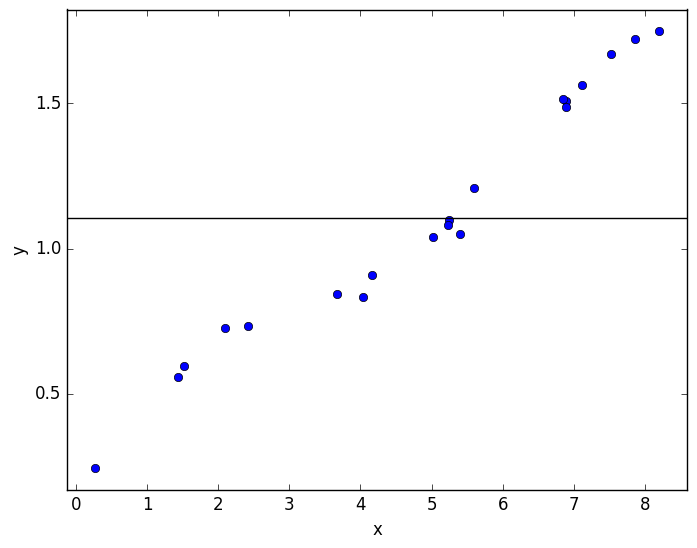

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328473090>

In [7]:
# plot the fit
clf() # clears the previous figure
plotdata()
plotline(0, w[1])

# Approximating with a line

In [8]:
X = [copy(x) ones(length(x))]

20×2 Array{Float64,2}:
 3.66796   1.0
 5.23879   1.0
 2.10256   1.0
 8.19338   1.0
 5.01371   1.0
 5.59355   1.0
 5.23559   1.0
 4.1587    1.0
 5.40152   1.0
 6.89567   1.0
 1.43836   1.0
 6.85137   1.0
 0.271377  1.0
 7.85383   1.0
 6.89278   1.0
 2.42258   1.0
 7.11323   1.0
 4.03459   1.0
 7.51799   1.0
 1.51662   1.0

In [9]:
w = X\y

2-element Array{Float64,1}:
 0.180877
 0.225941

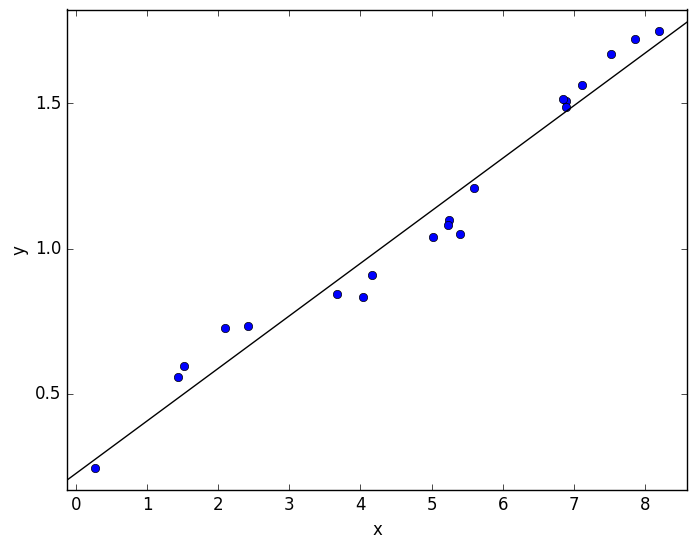

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3286b2b10>

In [10]:
# plot the fit
clf()
plotdata()
plotline(w[1], w[2])

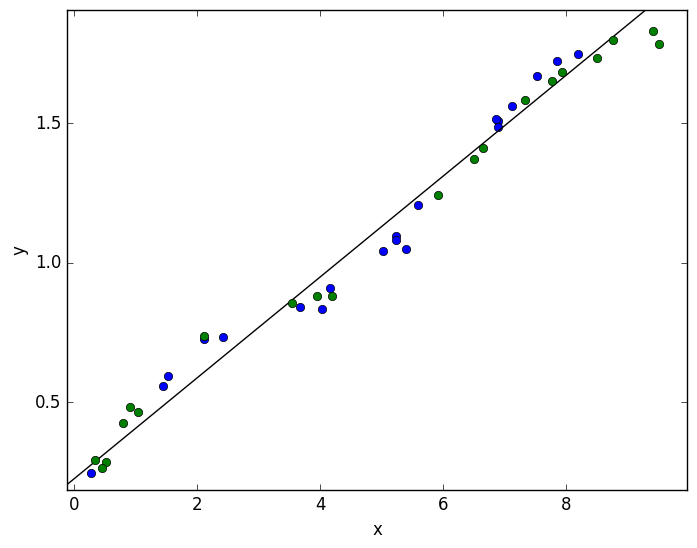

(-0.11964090999831162,9.96549823569426)

In [11]:
# plot fit on out of sample data
clf()
plotdata()
plotline(w[1], w[2])

xtest,ytest = sample_data(20)
plotdata(xtest,ytest)

# Approximating with a polynomial

In [12]:
# first, construct a Vandermonde matrix
max_order = 10

X = zeros(n, max_order+1)
for k=0:max_order
    X[:,k+1] = x.^k
end
X

20×11 Array{Float64,2}:
 1.0  3.66796   13.454       49.3486     …     1.20178e5      4.40809e5 
 1.0  5.23879   27.4449     143.778            2.97218e6      1.55706e7 
 1.0  2.10256    4.42078      9.29497        803.052       1688.47      
 1.0  8.19338   67.1315     550.034            1.66406e8      1.36343e9 
 1.0  5.01371   25.1373     126.031            2.00186e6      1.00368e7 
 1.0  5.59355   31.2878     175.01       …     5.36031e6      2.99832e7 
 1.0  5.23559   27.4114     143.515            2.95592e6      1.5476e7  
 1.0  4.1587    17.2947      71.9236           3.72061e5      1.54729e6 
 1.0  5.40152   29.1764     157.597            3.91418e6      2.11425e7 
 1.0  6.89567   47.5502     327.89             3.52522e7      2.43087e8 
 1.0  1.43836    2.06887      2.97577    …    26.3511        37.9022    
 1.0  6.85137   46.9413     321.613            3.32659e7      2.27917e8 
 1.0  0.271377   0.0736456    0.0199858        7.98292e-6     2.16638e-6
 1.0  7.85383   61.6827    

In [13]:
# solve least squares problem
w = X\y

11-element Array{Float64,1}:
   2.2722    
 -12.3185    
  22.5667    
 -19.7746    
  10.0734    
  -3.23117   
   0.673572  
  -0.091156  
   0.00772686
  -0.00037272
   7.80701e-6

In [14]:
"""computes our polynomial fit evaluated at x"""
function p(x; order = max_order, w = w)
    y = 0
    for k=0:order
        y += w[k+1]*x^k
    end
    return y
end

p

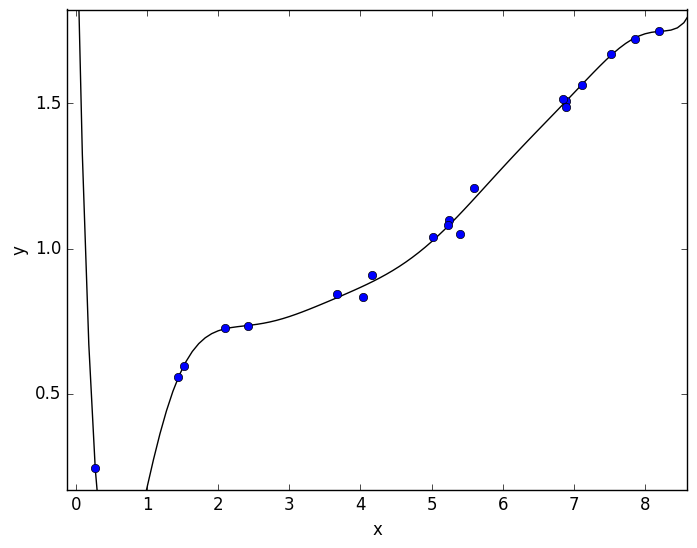

(-0.12472290408977926,8.589481557384227)

In [15]:
# plot fit
clf()
plotfunc(x -> p(x, order=max_order, w=w), xmin=0, xmax=9)
plotdata()

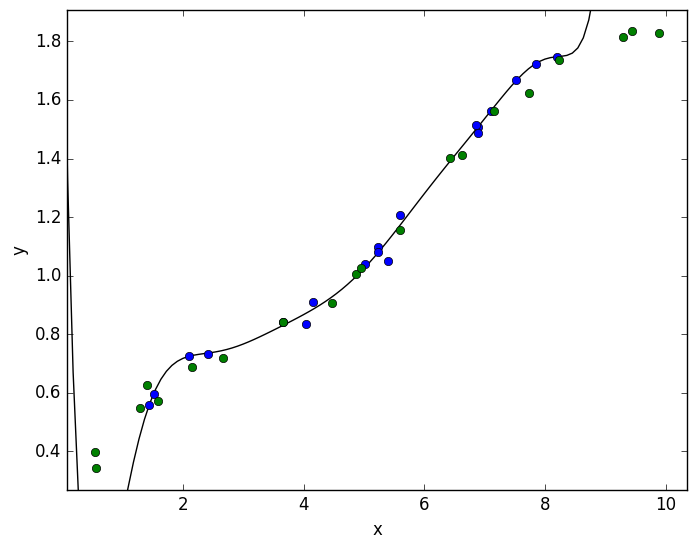

(0.080460210653297,10.355083301643862)

In [16]:
# plot fit on out of sample data
clf()
plotfunc(x -> p(x, order=max_order, w=w), xmin=0, xmax=9)
plotdata()

xtest,ytest = sample_data(20)
plotdata(xtest,ytest)

# Choosing the best model order

In [17]:
max_model_order = 10
rmse = Array(Float64, max_model_order+1) # array to store root mean square model errors
xtest,ytest = sample_data(50) # generate test set

for model_order = 0:max_model_order
    # form Vandermonde matrix
    X = zeros(n, model_order+1)
    for k=0:model_order
        X[:,k+1] = x.^k
    end
    
    # solve least squares problem
    w = X\y
    
    # compute test error
    ptest = [p(x, order=model_order, w=w) for x in xtest]
    rmse[model_order+1] = sqrt(mean((ytest - ptest).^2))
end
rmse

11-element Array{Float64,1}:
 0.466321 
 0.0810569
 0.120897 
 0.209955 
 0.0988893
 0.218405 
 0.0831323
 0.610933 
 0.0754457
 3.87297  
 3.41319  

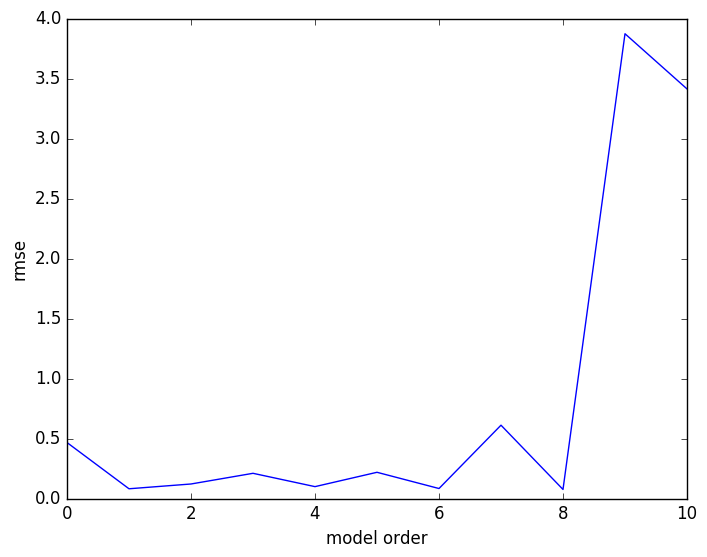

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32c0f6190>

In [18]:
xlabel("model order")
ylabel("rmse")
plot(rmse)

# Bootstrap estimators

In [19]:
# sample K data sets of n samples each and compute a model on each
# see how the models vary
n = 20
K = 10

models = zeros(K,2)
for k=1:K
    xk,yk = sample_data(n)
    Xk = [xk ones(n)]
    wk = Xk \ yk
    models[k,:] = wk
end

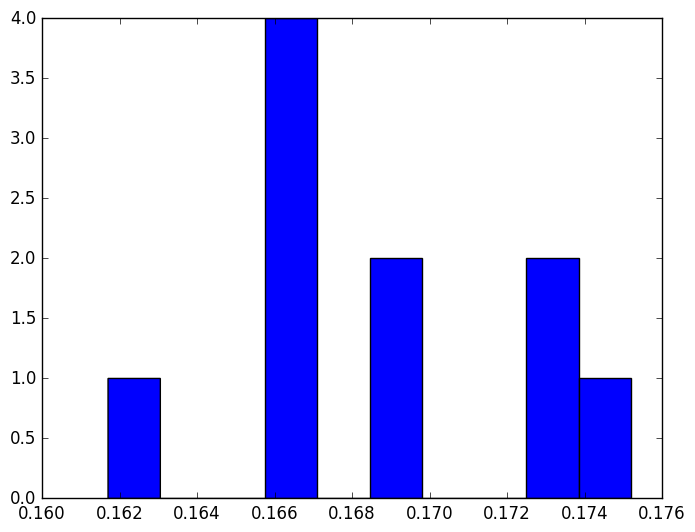

([1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,2.0,1.0],[0.161703,0.163052,0.164402,0.165751,0.167101,0.16845,0.1698,0.171149,0.172499,0.173849,0.175198],Any[PyObject <matplotlib.patches.Rectangle object at 0x32c366f10>,PyObject <matplotlib.patches.Rectangle object at 0x32c3745d0>,PyObject <matplotlib.patches.Rectangle object at 0x32c374c50>,PyObject <matplotlib.patches.Rectangle object at 0x32c384310>,PyObject <matplotlib.patches.Rectangle object at 0x32c384990>,PyObject <matplotlib.patches.Rectangle object at 0x32c384e90>,PyObject <matplotlib.patches.Rectangle object at 0x32c3916d0>,PyObject <matplotlib.patches.Rectangle object at 0x32c391d50>,PyObject <matplotlib.patches.Rectangle object at 0x32c39f410>,PyObject <matplotlib.patches.Rectangle object at 0x32c39fa90>])

In [20]:
# histogram of the distribution of the first coefficient
# could use to compute, eg, confidence intervals

plt[:hist](models[:,1])

In [21]:
mean(models,1)

1×2 Array{Float64,2}:
 0.16881  0.27753

In [22]:
var(models,1)

1×2 Array{Float64,2}:
 1.59647e-5  0.00114265

In [23]:
# can sample with replacement using rand
rand(1:15, 5)

# eg,
a = 0:.1:1.5
s = rand(1:15, 5)
[s a[s]]

5×2 Array{Float64,2}:
 13.0  1.2
  3.0  0.2
  1.0  0.0
 14.0  1.3
 14.0  1.3

In [24]:
# resample K bootstrap data sets of n samples each and compute a model on each
# see how the models vary
n = 20
K = 100

x,y = sample_data(n)

models = zeros(K,2)
for k=1:K
    mysample = rand(1:n,n)
    xk,yk = x[mysample], y[mysample]
    Xk = [xk ones(n)]
    wk = Xk \ yk
    models[k,:] = wk
end

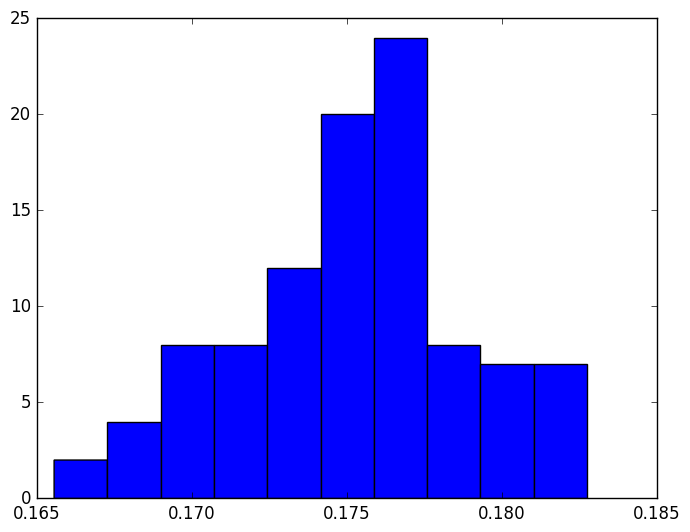

([2.0,4.0,8.0,8.0,12.0,20.0,24.0,8.0,7.0,7.0],[0.165558,0.167277,0.168995,0.170714,0.172433,0.174152,0.175871,0.17759,0.179309,0.181027,0.182746],Any[PyObject <matplotlib.patches.Rectangle object at 0x32c5cf4d0>,PyObject <matplotlib.patches.Rectangle object at 0x32c5cfb50>,PyObject <matplotlib.patches.Rectangle object at 0x32c5db210>,PyObject <matplotlib.patches.Rectangle object at 0x32c5db890>,PyObject <matplotlib.patches.Rectangle object at 0x32c5dbf10>,PyObject <matplotlib.patches.Rectangle object at 0x32c5e75d0>,PyObject <matplotlib.patches.Rectangle object at 0x32c5e7c50>,PyObject <matplotlib.patches.Rectangle object at 0x32c5f4310>,PyObject <matplotlib.patches.Rectangle object at 0x32c5f4990>,PyObject <matplotlib.patches.Rectangle object at 0x32c5f4e90>])

In [25]:
plt[:hist](models[:,1])

In [26]:
mean(models,1)

1×2 Array{Float64,2}:
 0.175217  0.249556

In [27]:
# as K increases, mean of the bootstrap models should converge to 
# the model fit on the original data set
X = [x ones(n)]
w = X \ y

2-element Array{Float64,1}:
 0.174752
 0.253001

In [28]:
var(models,1)

1×2 Array{Float64,2}:
 1.31712e-5  0.000412709